In [31]:
import binance_bot

bot = binance_bot.BinanceBot('BTC', 'USDT') # any two will do

def get_binance_coins(base='USDT'):
    coins = []
    info = bot.get_exchange_info()
    for symbol in info['symbols']:
        s = symbol['symbol']
        if s.endswith(base):
            coins.append(s[:-len(base)])
    return coins

In [32]:
from datetime import timedelta, timezone
import json

def update_history(coin, base):
    start = '20210101000000'; freq = 60; days = 365
    df = download_history_fast(f'{coin}{base}', start, freq=freq, days=days, cache=True)
    
    delta_start = (df.set_index(pd.to_datetime(df.index)).index[-1] + timedelta(hours=1)
                  ).tz_localize('UTC').astimezone('Europe/London').strftime('%Y%m%d%H%M%S')
#     print(f"Looking for data starting from {delta_start} Europe/London time.")
    try:
        df2 = download_history_fast(f'{coin}{base}', delta_start, freq=60, days=365, cache=True)
    except IndexError: # no more rows to download
        return df
    
    # update json with delta data
    orig_file = f"{coin}{base}-{start}-{freq}-{days}.json"
    delta_file = f"{coin}{base}-{delta_start}-{freq}-{days}.json"
    with open(orig_file) as f_orig:
        json_data = json.load(f_orig)
    with open(delta_file) as f_delta:
        json_data += json.load(f_delta)
    with open(orig_file, 'w') as f_orig_out:
        json.dump(json_data, f_orig_out)

    return download_history_fast(f'{coin}{base}', start, freq=freq, days=days, cache=True)
    
# update_history('IOTX', 'USDT')

In [33]:
from hypecommons import download_history_fast, plot, plt, pd, ema
from datetime import datetime

base = 'USDT'

coins = get_binance_coins(base=base)
rrf
DAYS_OF_HYPE = 1

hours_of_hype = 24 * DAYS_OF_HYPE

dfs = {}
for coin in coins:
    try:
#         df = download_history_fast(f'{coin}{base}', '20210101000000', freq=60, days=365, cache=True)
        df = update_history(coin, base)
    except:
        continue
    
    # calculated on the open, to maintain a fixed period of 1H between datapoints
    df['change'] = df['open'].diff() / df['open'].shift(1)
    
    df['hype'] = ema(df['change'], n=hours_of_hype) * hours_of_hype

    df = df.set_index(pd.to_datetime(df.index))
    df = df.resample('1H').ffill()
    
    df.dropna(inplace=True)
    
    # drop when EMA values are being estimated
    df.drop(df.index[:hours_of_hype], inplace=True)
    
#     # drop last row in some cases, due to different download times
#     df.drop(df[df.index >= datetime(2021, 11, 13, 15, 0)].index, inplace=True)

    dfs[coin] = df

## Some viz

In [34]:
def show_coins(column, dfs, coins, show=False, from_date=None):
    df_trends = pd.DataFrame(index=dfs[coins[0]].index)
    for coin in coins:
        df_trends = df_trends.join(dfs[coin][[column]])
        df_trends[coin] = df_trends[column]
        df_trends.drop(column, axis=1, inplace=True)
    if show:
        if from_date is not None:
            plot(plt.plot, df_trends[df_trends.index >= from_date], coins, fig_size=(16, 6))
        else:
            plot(plt.plot, df_trends, coins, fig_size=(16, 6))
    return df_trends

In [35]:
# _ = show_coins('trend', dfs, list(dfs.keys())[:12], show=True)

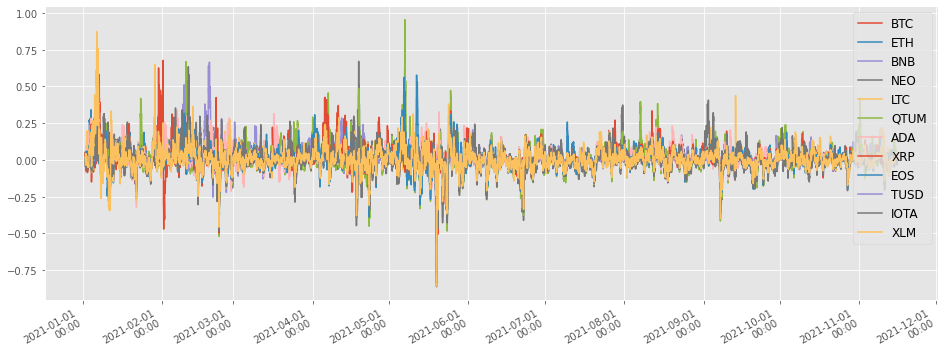

In [36]:
_ = show_coins('hype', dfs, list(dfs.keys())[:12], show=True)

In [37]:
from hypecommons import display_whole

df_hypes = show_coins('hype', dfs, list(dfs.keys()))

current_hype = pd.DataFrame(df_hypes[-6:].transpose()).dropna().sort_values(
    by=df_hypes.index[-1], ascending=False)

display_whole(current_hype.style.format('{:.4f}'))

,2021-11-15 13:00:00,2021-11-15 14:00:00,2021-11-15 15:00:00,2021-11-15 16:00:00,2021-11-15 17:00:00,2021-11-15 18:00:00
MITH,0.0391,0.0334,0.0344,0.0455,0.0676,0.7119
UMA,0.4337,0.5243,0.3787,0.3064,0.3271,0.2622
RAD,-0.0159,-0.0131,-0.0260,0.1057,0.1481,0.2307
KP3R,0.0093,-0.0092,0.0392,0.3174,0.2588,0.1810
GTO,0.0146,0.0415,0.0240,0.0304,0.0110,0.1440
TRXUP,0.2389,0.2453,0.1782,0.1844,0.1278,0.1341
LINKDOWN,0.0009,0.0038,0.0709,0.1081,0.1144,0.1312
DOTDOWN,-0.0835,-0.0579,0.0305,0.1128,0.1416,0.1238
WIN,0.1814,0.2366,0.3342,0.2360,0.1469,0.1222
SUSHIDOWN,0.0401,0.0671,0.0863,0.0977,0.1410,0.1216


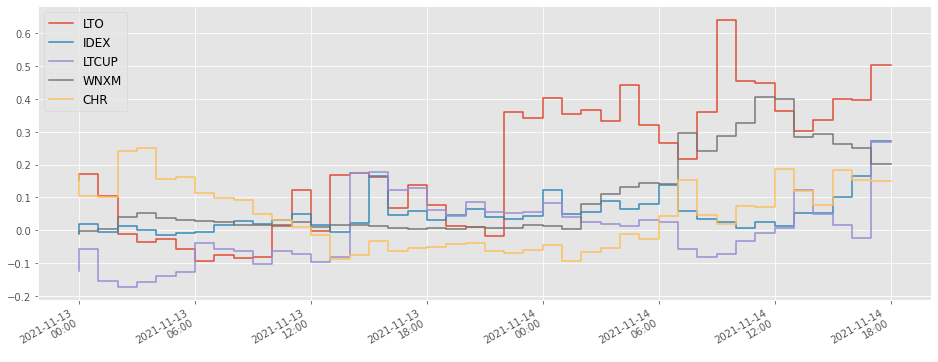

In [21]:
_ = show_coins('hype', dfs, current_hype.index[:5], show=True,
               from_date=datetime(2021, 11, 13))

In [ ]:
plot(plt.plot, df_trends[df_hypes.index > datetime(2021, 10, 14)], ['MATIC'], fig_size=(16, 6))

plot(plt.plot, df_hypes[df_hypes.index > datetime(2021, 10, 14)], ['MATIC'], fig_size=(16, 6), 
     baseline=[0], baseline_names=[''])

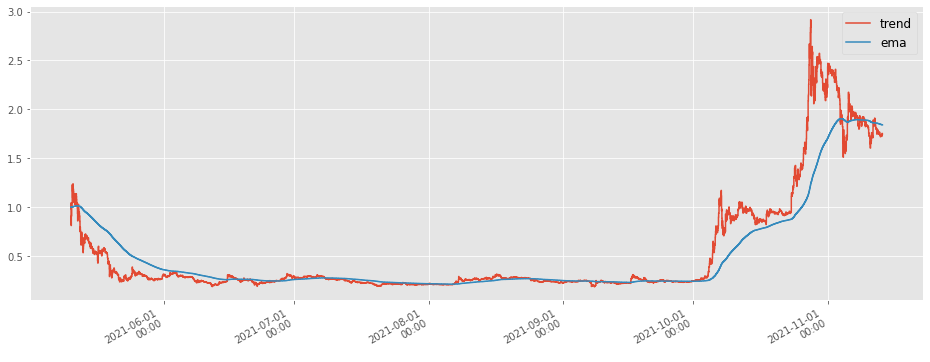

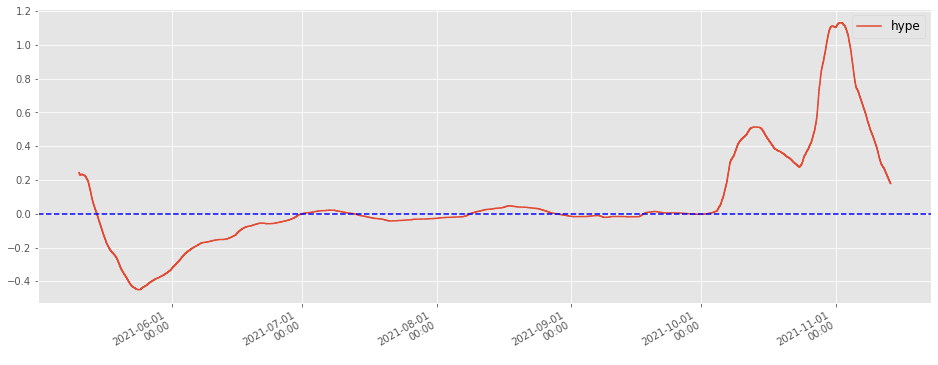

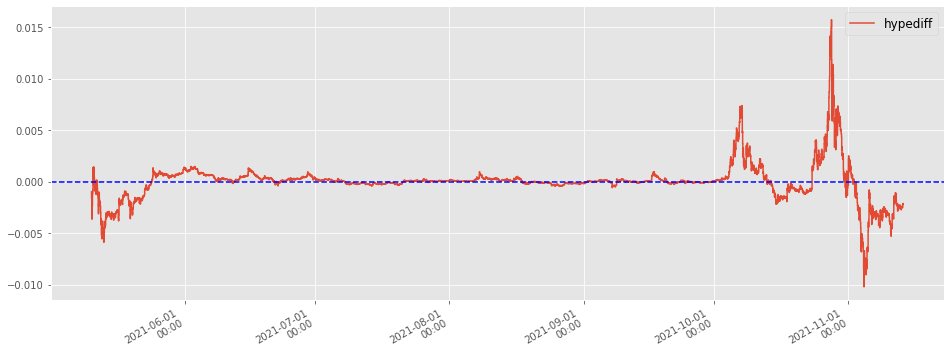

{'stake': 3.2826289304752505, 'hold': 1.6800388223875768}

In [98]:
def hype_cycle_strategy(coin, days_of_hype=14, show=False):

    hours_of_hype = 24 * days_of_hype
        
    df = download_history_fast(f'{coin}USDT', '20210101000000', freq=60, days=365, cache=True)

    df['trend'] = df['close'] / df.iloc[0]['close']

    df['ema'] = ema(df['trend'], n=hours_of_hype)

    df['hype'] = ema(df['ema'].diff(), n=hours_of_hype) * hours_of_hype

    df['hypediff'] = df['hype'].diff()

    df.dropna(inplace=True)
    df = df.set_index(pd.to_datetime(df.index))
    df = df.resample('1H').ffill()

    if show:
        plot(plt.plot, df[df.index > datetime(2021, 2, 1)], ['trend', 'ema'], fig_size=(16, 6))

        plot(plt.plot, df[df.index > datetime(2021, 2, 1)], ['hype'], fig_size=(16, 6), 
             baseline=[0], baseline_names=[''])

        plot(plt.plot, df[df.index > datetime(2021, 2, 1)], ['hypediff'], fig_size=(16, 6), 
             baseline=[0], baseline_names=[''])

    df['action'] = '----'
    df.loc[df[(df['hypediff'] > 0) & (df['hypediff'].shift(1) < 0)].index, 'action'] = 'BUY'
    df.loc[df[(df['hypediff'] < 0) & (df['hypediff'].shift(1) > 0)].index, 'action'] = 'SELL'

    # df[df['action'] != '----']

    stake = 1
    last_buy = None
    for i, row in df[df['action'] != '----'].iterrows():
        if row['action'] == 'BUY':
            last_buy = row['close']
        elif row['action'] == 'SELL':
            if last_buy is None:
                # ignore SELL before BUY
                continue
            stake = stake / last_buy * row['close']
            stake = stake * (1-0.00075)

    hold = df['close'].iloc[-1] / df['close'].iloc[0]

    return {'stake': stake, 'hold': hold}


hype_cycle_strategy('SHIB', days_of_hype=14, show=True)

In [111]:
def run(coin):
    results = []
    for days in range(1, 22):
        res = {'days': days}
        results.append({**res, **hype_cycle_strategy(coin, days_of_hype=days)})
    return pd.DataFrame(results)

In [115]:
from hypecommons import display

for coin in coins:
    print(f"---- {coin} ----")
    results = run(coin)
    display(results[results['stake'] > results['hold']])

---- BTC ----


,days,stake,hold
12,13,2.257983,2.20339
13,14,2.313702,2.20339


---- ETH ----


,days,stake,hold


---- BNB ----


,days,stake,hold


---- LTC ----


,days,stake,hold
19,20,2.040755,1.899797
20,21,2.014602,1.899797


---- DOT ----


,days,stake,hold


---- MATIC ----


,days,stake,hold


---- ADA ----


,days,stake,hold


---- SRM ----


,days,stake,hold


---- LUNA ----


,days,stake,hold


---- DOGE ----


,days,stake,hold


---- SHIB ----


,days,stake,hold
4,5,1.611440,1.576189
7,8,1.630190,1.576189
8,9,2.322987,1.576189
9,10,3.247107,1.576189
10,11,3.169099,1.576189
11,12,3.353741,1.576189
12,13,3.685707,1.576189
13,14,3.282629,1.576189
14,15,2.624463,1.576189
15,16,2.809046,1.576189


---- SOL ----


,days,stake,hold


---- VET ----


,days,stake,hold


---- XLM ----


,days,stake,hold


---- XRP ----


,days,stake,hold


## Exploration

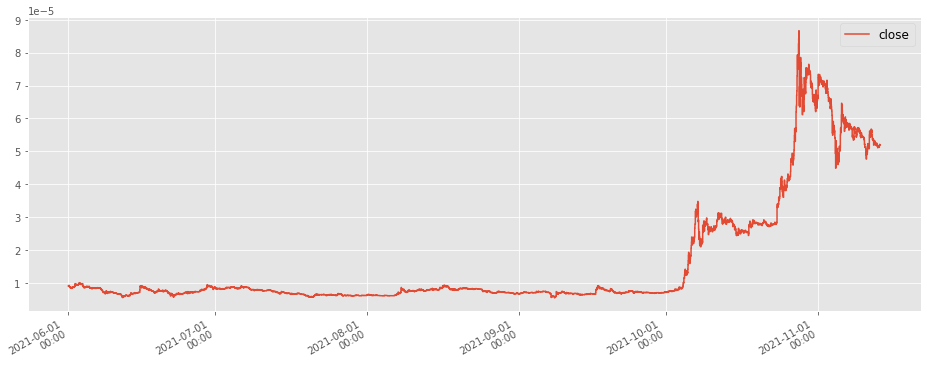

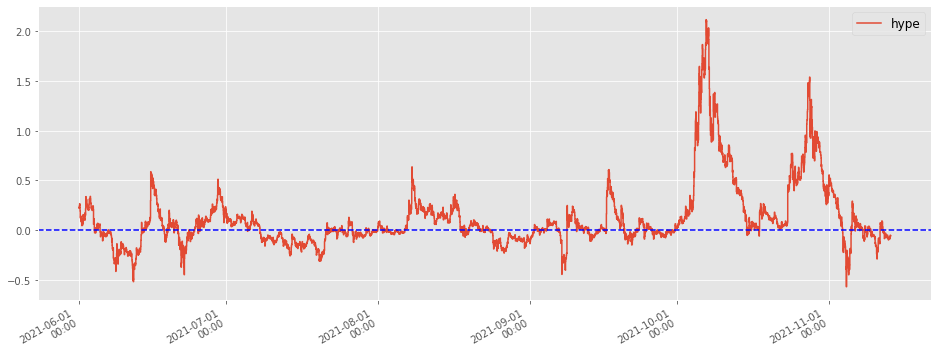

In [136]:
def find_hype_cycle(coin, days_of_hype=14, show=True):

    hours_of_hype = 24 * days_of_hype
        
    df = download_history_fast(f'{coin}USDT', '20210101000000', freq=60, days=365, cache=True)

    df['change'] = df['close'].diff() / df['close'].shift(1)
    
    df['hype'] = ema(df['change'], n=hours_of_hype) * hours_of_hype

#     df['accel'] = ema(df['hype'].diff(), n=hours_of_hype) * hours_of_hype

    df.dropna(inplace=True)
    df = df.set_index(pd.to_datetime(df.index))
    df = df.resample('1H').ffill()

    if show:
        plot(plt.plot, df[df.index > datetime(2021, 6, 1)], ['close'], fig_size=(16, 6))
        
        plot(plt.plot, df[df.index > datetime(2021, 6, 1)], ['hype'], fig_size=(16, 6), 
             baseline=[0], baseline_names=[''])

#         plot(plt.plot, df[df.index > datetime(2021, 4, 1)], ['accel'], fig_size=(16, 6), 
#              baseline=[0], baseline_names=[''])


find_hype_cycle('SHIB', days_of_hype=7)

In [192]:
coin='BNB'
df = download_history_fast(f'{coin}{base}', '20210101000000', freq = 60, days = 365, cache=True)